## What is Portfolio VQE? 
https://qiskit-community.github.io/qiskit-algorithms/tutorials/index.html

> **Portfolio optimization** is a fundamental problem in finance that focuses on allocating capital across multiple assets in an optimal way.

> As the number of assets increases, **traditional portfolio optimization methods face computational limitations**. Classical algorithms often struggle with:

    - Complex objective functions  
    - Non-convex landscapes  
    - Combinatorial explosion in large portfolios  

> **Quantum computing** introduces new paradigms for tackling such optimization problems more efficiently by exploiting quantum parallelism.

> The **Variational Quantum Eigensolver (VQE)** is a hybrid classical–quantum algorithm that:
    1. Maps portfolio optimization to an energy minimization problem  
    2. Uses parameterized quantum circuits  
    3. Is well-suited for **Noisy Intermediate-Scale Quantum (NISQ)** devices  

> Portfolio VQE applies VQE to financial optimization, enabling near-term quantum hardware to address realistic portfolio selection problems.


#### A Simple Example

* Consider an investor allocating **₹100** across **three assets** with different risk–return profiles.So out bojective is to **maximize expected returns while minimizing overall risk**.

* As the number of assets increases, evaluating all possible allocation combinations becomes **computationally infeasible** for classical methods due to:

  * **Non-convex optimization landscapes**
        
  * **Multiple local optima**
        
  * **Combinatorial explosion of possible portfolios**
        

* **Portfolio VQE** addresses this challenge by:
    - Encoding asset allocation decisions into **qubits**
    - Reformulating the portfolio objective as a **Hamiltonian**, where *lower energy corresponds to a better portfolio*
    - Using a **parameterized quantum circuit** to generate candidate portfolios
    - Employing a **classical optimizer** to iteratively update circuit parameters

* The algorithm converges to the **minimum energy state**, which represents the **optimal portfolio allocation**.


## Portfolio Optimization and Modern Portfolio Theory (MPT)

**Portfolio optimization** is the process of selecting a combination of assets in an investment portfolio that **maximizes expected returns while minimizing risk**.

**Modern Portfolio Theory (MPT)** is one of the most well-known mathematical frameworks used to address this problem:  
https://en.wikipedia.org/wiki/Modern_portfolio_theory

In MPT:

- The **expected return** of an asset is estimated using the **mean of its historical return distribution**
- The **risk (volatility)** is defined as the **standard deviation** of the same distribution

For an asset with price series $\{p_i\}$  over days $(i = 1 \sim N)$, the **return distribution** is defined as $\{r_i\}$, where:

$\[  r_i = \frac {p_{ i } - p_{ i-1 }}{ p_{ i-1 }}   \$]

This return distribution forms the basis for calculating:
- Mean return (expected return)
- Variance and standard deviation (risk)

These statistical measures are then used to construct an optimized portfolio under the MPT framework.


Data from https://github.com/lvzggg/portfolio_vqe 

### IN LAYMAN TERMS :: 

## STEP 0 — Problem Definition (Why This Code Exists)

📌 **Corresponding code starts before any imports**

We solve a **portfolio optimization problem**, where the goal is to select a subset of stocks such that:

- Risk is minimized  
- Expected return is maximized  
- A fixed number of stocks is selected  

This problem is computationally hard for large portfolios and is therefore solved using:
- A **classical solver** (ground truth)
- A **quantum solver using VQE**


### STEP 1 — Extracting the Dataset  

* The dataset is stored in a ZIP file.  
* We must extract it so Python can read CSV files from it.

* We begin by loading historical financial data required for portfolio optimization:

    - **Covariance matrix** ($\sigma$)  :  captures asset-to-asset risk correlation  
    - **Stock returns**  :  daily returns for each asset  
    - **Expected returns** ($\mu_i$)  :  mean of historical returns  

* These quantities are essential for constructing the portfolio optimization objective.
  
### Mathematical Meaning of the Covariance Matrix

For assets *i* and *j*, the covariance is defined as:

$$
\Sigma_{ij} = \mathbb{E}\big[(r_i - \mu_i)(r_j - \mu_j)\big]
$$

where:

- $r_i$  is the return of asset *i*
- $\mu_i$ is the expected return of asset *i*
  
The covariance matrix captures **portfolio risk**.


In [1]:
## STEP 1 — Data Extraction  
import zipfile, os                        #used to unzip dataset files and to create folders and list files

zip_path = 'portfolio_vqe_data.zip'       #if data is downloaded from repo from .zip file then
extract_dir = 'portfolio_vqe_data'        # if folder cloned from git link

# Case 1: Dataset folder already exists and is not empty
if os.path.exists(extract_dir) and os.listdir(extract_dir):
    print(f"Dataset already exists in '{extract_dir}'. Using existing data.")

# Case 2: Dataset folder does not exist or is empty → extract ZIP
else:
    print(f"Extracting dataset from '{zip_path}' into '{extract_dir}'...")
    os.makedirs(extract_dir, exist_ok=True)  #extracting the in case of zipped , then extracted
    
    with zipfile.ZipFile(zip_path, 'r') as z:   # extracting process
        z.extractall(extract_dir)

os.listdir(extract_dir)                  # extracted in this directory

Dataset already exists in 'portfolio_vqe_data'. Using existing data.


['covariance_matrix_2024.csv',
 'expected_returns_2024.csv',
 'README.md',
 'stock_prices_2024.csv',
 'stock_returns_2024.csv']

In [2]:
os.listdir('portfolio_vqe_data')         # listing the files contains by downloaded data

['covariance_matrix_2024.csv',
 'expected_returns_2024.csv',
 'README.md',
 'stock_prices_2024.csv',
 'stock_returns_2024.csv']

### STEP 2 — Importing Scientific & Quantum Libraries  

Now we load libraries for:  
- Numerical computation  
- Data analysis  
- Quantum optimization

In [3]:
import numpy as np                                                         # importting for mathematical operations
import pandas as pd                                                        # for Data analysis
from qiskit_finance.applications.optimization import PortfolioOptimization # Provides financial modeling utilities
from qiskit.circuit.library import TwoLocal                                # A parameterized quantum circuit used in VQE
from qiskit_algorithms import SamplingVQE                                  # quantum optimization algorithm
from qiskit_algorithms.optimizers import COBYLA                            # classical optimizer that tunes circuit parameters
from qiskit_aer.primitives import Sampler                                  # simulates quantum measurements
from qiskit_optimization.algorithms import MinimumEigenOptimizer           # connects optimization problem to quantum solvers

### 🔹 STEP 3 — Loading and Inspecting Data

Portfolio optimization needs:  
- Risk → covariance matrix  
- Return → expected returns  
- Market data → prices & returns

In [4]:
#visualizing data
df_c_24 = pd.read_csv('portfolio_vqe_data/covariance_matrix_2024.csv')    # covariance_matrix → how risky stock combinations are
df_e_24 = pd.read_csv('portfolio_vqe_data/expected_returns_2024.csv')     # expected_returns → average profit
df_sp_24 = pd.read_csv('portfolio_vqe_data/stock_prices_2024.csv')        # stock_prices → historical prices
df_sr_24 = pd.read_csv('portfolio_vqe_data/stock_returns_2024.csv')       # stock_returns → daily returns

print(df_c_24.shape)                                                      # .shape → shows matrix size
df_c_24.head()                                                            # .head() → preview first rows

(12, 13)


,Unnamed: 0,600519.SS,600036.SS,601318.SS,600406.SS,601857.SS,601988.SS,AAPL,MSFT,AMZN,GOOGL,NVDA,TSLA
0,600519.SS,0.000284,0.000144,0.000205,0.000058,0.000078,0.000034,0.000003,-2.454449e-06,4.251102e-06,0.000036,0.000044,1.457948e-05
1,600036.SS,0.000144,0.000227,0.000211,0.000057,0.000122,0.000093,0.000002,-7.396992e-06,-1.300673e-06,0.000036,0.000020,-9.596900e-07
2,601318.SS,0.000205,0.000211,0.000323,0.000085,0.000120,0.000067,0.000021,6.739278e-06,1.738954e-05,0.000052,0.000066,4.563272e-05
3,600406.SS,0.000058,0.000057,0.000085,0.000224,0.000076,0.000020,0.000003,-9.458268e-07,8.094970e-07,-0.000010,0.000011,-1.447082e-06
4,601857.SS,0.000078,0.000122,0.000120,0.000076,0.000423,0.000118,-0.000004,9.481942e-06,2.508072e-05,0.000055,0.000094,-6.756476e-05


In [5]:
print(df_c_24.shape)      # .shape → shows matrix size

(12, 13)


In [6]:
print(df_e_24.shape) # .shape → shows matrix size
df_e_24.head()       # .head() → preview first rows  

(1, 12)


,600519.SS,600036.SS,601318.SS,600406.SS,601857.SS,601988.SS,AAPL,MSFT,AMZN,GOOGL,NVDA,TSLA
0,-0.000107,0.001738,0.001566,0.000709,0.0013,0.001512,0.001298,0.00063,0.001656,0.00142,0.00458,0.002762


In [7]:
print(df_sp_24.shape) # .shape → shows matrix size
df_sp_24.head()       # .head() → preview first rows

(260, 13)


,Date,600519.SS,600036.SS,601318.SS,600406.SS,601857.SS,601988.SS,AAPL,MSFT,AMZN,GOOGL,NVDA,TSLA
0,2024-01-02,1594.071289,24.933294,36.392601,21.084110,6.596822,3.651162,184.081482,366.707367,149.929993,137.346283,48.146576,248.419998
1,2024-01-03,1602.576050,25.105062,36.328056,21.370319,6.726172,3.687582,182.703171,366.440430,148.470001,138.091827,47.547840,238.449997
2,2024-01-04,1578.925293,25.141224,35.867043,21.351240,6.864761,3.769529,180.382812,363.810272,144.570007,135.576889,47.976654,237.929993
3,2024-01-05,1573.589600,25.575161,35.931583,21.169975,6.920196,3.751318,179.658936,363.622437,145.240005,134.920822,49.075157,237.490005
4,2024-01-08,1555.265015,25.430513,35.452126,20.912386,6.901718,3.733108,184.002167,370.484528,149.100006,138.012299,52.229752,240.449997


In [8]:
print(df_sr_24.shape) # .shape → shows matrix size
df_sr_24.head()       # .head() → preview first rows

(259, 13)


,Date,600519.SS,600036.SS,601318.SS,600406.SS,601857.SS,601988.SS,AAPL,MSFT,AMZN,GOOGL,NVDA,TSLA
0,2024-01-03,0.005335,0.006889,-0.001774,0.013575,0.019608,0.009975,-0.007488,-0.000728,-0.009738,0.005428,-0.012436,-0.040134
1,2024-01-04,-0.014758,0.001440,-0.012690,-0.000893,0.020604,0.022222,-0.012700,-0.007178,-0.026268,-0.018212,0.009019,-0.002181
2,2024-01-05,-0.003379,0.017260,0.001799,-0.008490,0.008075,-0.004831,-0.004013,-0.000516,0.004634,-0.004839,0.022897,-0.001849
3,2024-01-08,-0.011645,-0.005656,-0.013344,-0.012168,-0.002670,-0.004854,0.024175,0.018871,0.026577,0.022913,0.064281,0.012464
4,2024-01-09,-0.001819,0.001422,-0.001820,-0.004106,-0.001339,0.000000,-0.002263,0.002936,0.015225,0.015197,0.016975,-0.022832


In [9]:
print("the shape of covariance matrix: ",df_c_24.shape)  # .shape → shows matrix size
print("the shape of expeced return: ",df_e_24.shape)     # .shape → shows matrix size
print("the shape of stock price: ",df_sp_24.shape)       # .shape → shows matrix size
print("the shape of stock return: ",df_sr_24.shape)      # .shape → shows matrix size

the shape of covariance matrix:  (12, 13)
the shape of expeced return:  (1, 12)
the shape of stock price:  (260, 13)
the shape of stock return:  (259, 13)


### STEP 4 — Cleaning Data for Optimization

- Quantum optimizers require pure numerical matrices.  
- We remove labels, dates, and text.

In [10]:
# STEP A — Loading & cleaning the data which would be compatible to my code

raw_cov = pd.read_csv("portfolio_vqe_data/covariance_matrix_2024.csv")    #Removes first row/column covariances row names (Labels)
sigma = raw_cov.iloc[1:, 1:].astype(float).values             #Converts remaining values to numbers and sigma is cleaned covarience matrix

# Extract tickers from the header (skip first empty cell)
tickers = list(raw_cov.columns[1:])                            #Extracts stock names
tickers = tickers[:len(raw_cov)-1]                             # ensure alignment with covariance rows and Ensures number of tickers matches matrix size
print(" Tickers:", tickers)          

print("\n Clean covariance matrix shape:", sigma.shape) 

# Number of assets from covariance
N = sigma.shape[0]                                             # N = number of assets (stocks)

# B. Load stock returns
raw_returns = pd.read_csv("portfolio_vqe_data/stock_returns_2024.csv")     # picking stock_returns 2024
returns_only = raw_returns.iloc[:, 1:]                         # drop date column 

# C. Compute expected returns
mu_all = returns_only.mean(axis=0).values                      # Computes average return per stock

# ⚠ Fix: match mu length to sigma dimension
mu = mu_all[:N]                                                #Trims to match covariance matrix size

print(" \n Expected returns length:", len(mu)) 
print(" \n Number of assets:", N)

 Tickers: ['600519.SS', '600036.SS', '601318.SS', '600406.SS', '601857.SS', '601988.SS', 'AAPL', 'MSFT', 'AMZN', 'GOOGL', 'NVDA']

 Clean covariance matrix shape: (11, 12)
 
 Expected returns length: 11
 
 Number of assets: 11


### STEP 5 — Visualizing the Data

- Understanding the data visually. 
- **Covariance Heatmap** Bright = high risk together


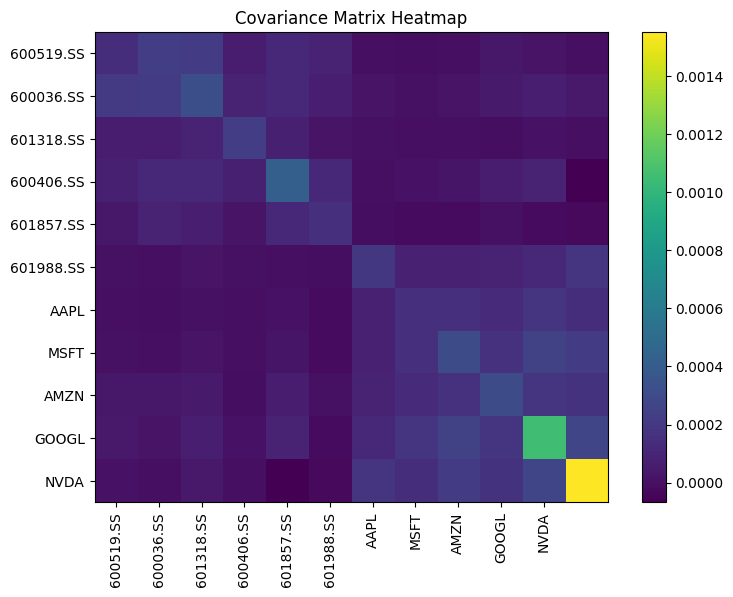

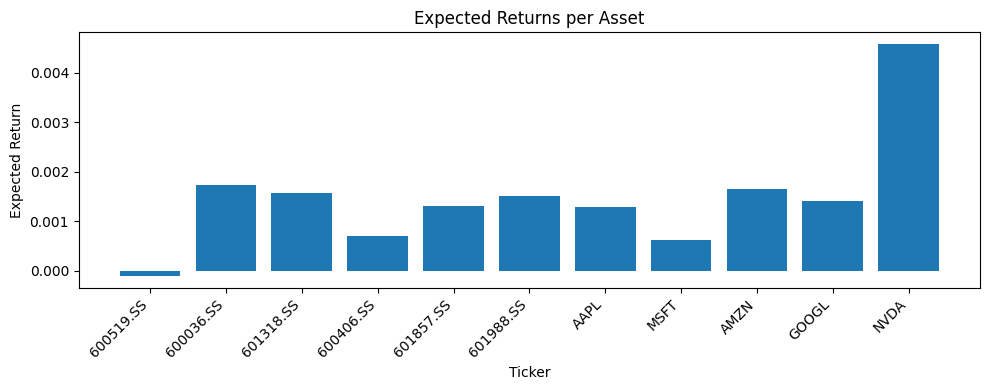

In [11]:
 # VISUALIZATIONS of cleaned data
import matplotlib.pyplot as plt


# Covariance heatmap with tickers
plt.figure(figsize=(8,6))
plt.imshow(sigma, cmap="viridis")                       # Shows which stocks move together
plt.title("Covariance Matrix Heatmap")
plt.colorbar()
plt.xticks(range(N), tickers, rotation=90)
plt.yticks(range(N), tickers)
plt.tight_layout()
plt.show()

# Expected returns bar chart with tickers
plt.figure(figsize=(10,4))
plt.bar(tickers, mu)                                    # Shows which stocks give higher returns
plt.title("Expected Returns per Asset")
plt.xlabel("Ticker")
plt.ylabel("Expected Return")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### 🔹 STEP 6 — Building the Optimization Problem as a QUBO 

We define a **binary decision variable** for each asset:

$$
x_i \in \{0,1\}
$$

where:
- $x_i$ = 1: asset *i* is selected  
- $x_i$ = 0: asset *i* is not selected  

Let **N** be the total number of assets.

🧠 **Core idea**  
We want to minimize:  
$$ q \cdot x^T \Sigma x - \mu^T x $$

Where:  
- $x$ = decision (0 = don't pick stock, 1 = pick)  
- First term → risk  
- Second term → return
- $q$ controls risk vs return tradeoff  
- $budget$ = number of stocks allowed

In [12]:
# STEP B — Building QUBO MANUALLY

q = 0.5                                           # controls risk vs return tradeoff
budget = N // 2                                   # = number of stocks allowed

# Objective: minimize  q * xᵀΣx  – μᵀx ; it Converts formula into optimizer format
Q = q * sigma
c = -mu

from qiskit_optimization import QuadraticProgram

qp = QuadraticProgram()                           # Container for optimization problem

# Adding binary decision variables
for i in range(N):
    qp.binary_var(f"x{i}")                        # Each stock is a binary decision variable

# Setting linear term
qp.objective.linear = c.tolist()   

# Initializing quadratic matrix with zeros
quad_matrix = np.zeros((N, N))                    # Sets the optimization objective

# Filling quadratic matrix
for i in range(N):
    for j in range(N):
        quad_matrix[i, j] = Q[i, j]

# Assigning quadratic part
qp.objective.quadratic = quad_matrix.tolist()

# Adding budget constraint 
qp.linear_constraint(
    linear={f"x{i}": 1 for i in range(N)},
    sense="==",
    rhs=budget,
    name="budget"
)

print("\n Quadratic Program constructed successfully:")
print(qp)


 Quadratic Program constructed successfully:
minimize 7.195609704585e-05*x0^2 + 0.00021617873351924998*x0*x1 + 1.7423025522744246e-05*x0*x10 + 0.00013435708935989043*x0*x2 + 6.710480741425077e-05*x0*x3 + 7.802985633204264e-05*x0*x4 + 4.8351730419549014e-05*x0*x5 - 3.3488849087342017e-07*x0*x6 - 1.5729450070290559e-06*x0*x7 + 1.7264586336361705e-05*x0*x8 + 4.015787214344938e-05*x0*x9 + 0.0001054238359804*x1^2 + 3.252866292282365e-05*x1*x10 + 0.0001900475177637449*x1*x2 + 0.00010336606866678222*x1*x3 + 0.00010684964482542898*x1*x4 + 3.42736771928674e-05*x1*x5 + 6.771946553923116e-06*x1*x6 + 2.7193026829005237e-06*x1*x7 + 2.6778189636362626e-05*x1*x8 + 3.614408884582453e-05*x1*x9 + 0.00013694850066235*x10^2 + 2.8400718102039223e-05*x2*x10 + 4.257862687978222e-05*x2^2 + 0.00017198432692875*x2*x3 + 7.119093464283172e-05*x2*x4 + 2.0405823789072925e-05*x2*x5 + 4.816384224764438e-06*x2*x6 + 8.221858400427818e-06*x2*x7 + 2.6415551785971827e-05*x2*x8 + 2.8001531809515697e-05*x2*x9 + 4.627364950

### 🔹 STEP 7 — Classical Solution (Ground Truth)

### Portfolio Objective Function

The portfolio optimization objective is:

$$
\min_{x \in \{0,1\}^N}
\quad
q \cdot x^T \Sigma x - \mu^T x
$$

where:

- $x^T \Sigma x$ represents **portfolio risk**  
- $\mu^T x$ represents **portfolio return**  
- $q$ is the **risk-aversion parameter**


This is a **quadratic binary optimization problem**.

### QUBO Matrix Form

The objective can be written in standard QUBO form:

$$
\min_x \; x^T Q x + c^T x
$$

with:

- $Q = q\,\Sigma$  
- $c = -\mu$

This form is directly compatible with quantum optimization algorithms.

### Budget Constraint

We enforce a fixed investment budget:

\[
\sum_{i=1}^{N} x_i = B
\]

where \( B \) is the number of assets to be selected.

This constraint ensures realistic portfolio construction.

## Classical Optimization (Benchmark)

Before using a quantum algorithm, we solve the QUBO using a **classical exact solver**.

This provides:
- A reference optimal solution
- A baseline for comparison with quantum results

The classical solver finds the minimum eigenvalue of the QUBO Hamiltonian exactly.


🧠 **Why we do this?**  
To verify if quantum solution is correct.

- $x$ → chosen stocks  
- $fval$ → optimal value


In [13]:
# STEP C — CLASSICAL SOLVER


from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms import NumPyMinimumEigensolver

classical_solver = MinimumEigenOptimizer(NumPyMinimumEigensolver())
classical_result = classical_solver.solve(qp)

print("\n===== CLASSICAL OPTIMAL RESULT =====")
print("x =", classical_result.x)
print("value =", classical_result.fval)



===== CLASSICAL OPTIMAL RESULT =====
x = [0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1.]
value = -0.010046125805780726


### 🔹 STEP 8 — Quantum Solution using VQE

🧠 **What is VQE?**  
- Uses a quantum circuit  
- Parameters are optimized classically  
- Measurements guide optimization 
- Creates a parameterized quantum circuit  
- RY rotations + CZ entanglement
- Classical optimizer tuning circuit parameters


#### Quantum Optimization using VQE

We now solve the same QUBO problem using the
**Variational Quantum Eigensolver (VQE)**.

VQE is a **hybrid quantum–classical algorithm** suitable for
**Noisy Intermediate-Scale Quantum (NISQ)** devices.

#### Mapping QUBO to a Quantum Hamiltonian

The QUBO objective corresponds to an Ising Hamiltonian:

$$
H = \sum_i h_i Z_i + \sum_{i<j} J_{ij} Z_i Z_j
$$

The ground state of this Hamiltonian encodes the optimal portfolio selection.


### Variational Ansatz and Optimization

- A parameterized quantum circuit (ansatz) is constructed using `TwoLocal`
- Classical optimizer (COBYLA) updates circuit parameters
- The quantum backend estimates expectation values

The objective is to minimize:

$$
\langle \psi(\theta) | H | \psi(\theta) \rangle
$$






In [14]:
# STEP D —  QUANTUM VQE SOLVER WITH CONVERGENCE TRACKING


from qiskit.circuit.library import TwoLocal
from qiskit_algorithms.optimizers import COBYLA, OptimizerResult
from qiskit_algorithms import SamplingVQE
from qiskit_aer.primitives import Sampler

# Track convergence
vqe_values = []                                # Stores objective value per iteration

def callback(eval_count, params, value, meta): # Called after each quantum evaluation
    vqe_values.append(value)

ansatz = TwoLocal(N, "ry", "cz", reps=1)       # Creates a parameterized quantum circuit with 'ry' rotations + 'cz' entanglement
optimizer = COBYLA(maxiter=100)                # Classical optimizer tuning circuit parameters

# Complete VQE algorithm
vqe = SamplingVQE(
    sampler=Sampler(),
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback
)

quantum_solver = MinimumEigenOptimizer(vqe)    # Solves optimization using quantum method
quantum_result = quantum_solver.solve(qp)

print("\n===== QUANTUM (VQE) RESULT =====")
print("x =", quantum_result.x)
print("value =", quantum_result.fval)



===== QUANTUM (VQE) RESULT =====
x = [0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1.]
value = -0.009242033738961486


### 🔹 STEP 9 — Convergence Plot

### Convergence Tracking

At each VQE iteration, the objective value is recorded.

This allows visualization of:
- Convergence behavior
- Optimization stability
- Performance of the quantum solver


🧠 **Purpose**  
Shows learning behavior of quantum algorithm :

- **X-axis** → iteration  
- **Y-axis** → objective value



/home/vandna/anaconda3/envs/mqt0/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/vandna/anaconda3/envs/mqt0/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


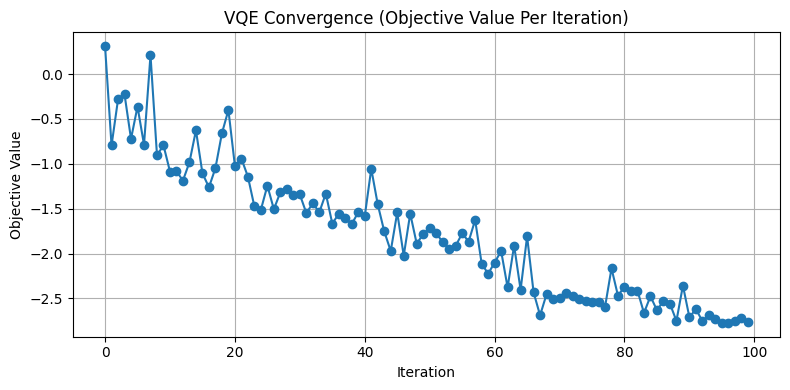

In [15]:
# my VQE CONVERGENCE PLOT
plt.figure(figsize=(8,4))
plt.plot(vqe_values, marker='o')
plt.title("VQE Convergence (Objective Value Per Iteration)")
plt.xlabel("Iteration")
plt.ylabel("Objective Value")
plt.grid(True)
plt.tight_layout()
plt.show()

### 🔹 STEP 10 — Classical vs Quantum Comparison

* We compare:

    - **Classical optimal objective value**
    - **Quantum (VQE) objective value**



* This comparison shows how close the quantum solution is to the classical optimum,
given NISQ-era constraints.


* Visual proof of how close quantum solution is to classical.


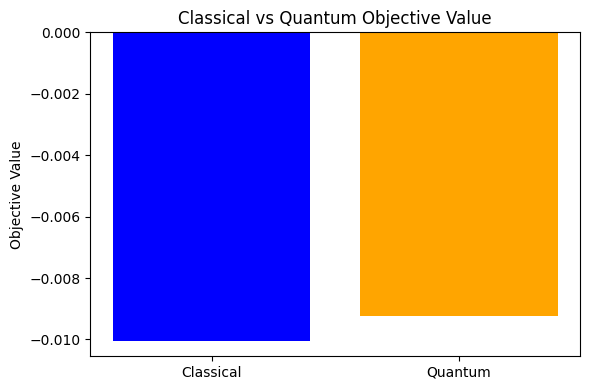

In [16]:
# BAR CHART: CLASSICAL VS QUANTUM PERFORMANCE

classical_val = classical_result.fval
quantum_val = quantum_result.fval

plt.figure(figsize=(6,4))
plt.bar(["Classical", "Quantum"], [classical_val, quantum_val], color=["blue","orange"])
plt.title("Classical vs Quantum Objective Value")
plt.ylabel("Objective Value")
plt.tight_layout()
plt.show()